![Advertising](img/advertising.jpeg)

**Prédire les ventes à partir des investissements publicitaires**

**Contexte** :

Une entreprise souhaite mieux comprendre l’impact de ses dépenses publicitaires sur ses ventes. Elle dispose d’un jeu de données ([`data/advertising.csv`](data/advertising.csv)) comprenant les montants investis dans trois canaux de communication (TV, radio, presse écrite) ainsi que les ventes correspondantes. Vous êtes chargé·e d’exploiter ces données pour construire un modèle de prédiction fiable.

⸻

🎯 **Objectif** :

Construire un modèle de régression linéaire permettant de prédire les ventes en fonction des investissements publicitaires dans les trois médias, en suivant un pipeline de modélisation complet.

- Exploration des données (EDA) :
    - Analyse descriptive
    - Visualisation des relations entre variables
    - Identification des corrélations
- Préparation des données :
    - Nettoyage des données (valeurs manquantes, outliers)
    - Normalisation ou standardisation si nécessaire
    - Séparation train/test
- Modélisation :
    - Implémentation d’un modèle de régression linéaire
- Évaluation :
    - Utilisation de métriques pertinentes : RMSE, R², MAE
- Intégration simple du modèle dans un script interactif
    - Intégrer votre modèle dans un script Python simple qui permet à un utilisateur de faire une prédiction à partir de nouvelles données.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv("data/advertising.csv")

# 1. Exploration de données

## Aperçu rapide contenu/structure des données

In [3]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


# 1. Analyses univariées

Les histogrammes montrent que les variables TV et Radio sont bien réparties => favorise un apprentissage efficace du modèle.

En revanche, Newspaper est très asymétrique => ce qui peut réduire son influence dan le modèle et même le nuire.

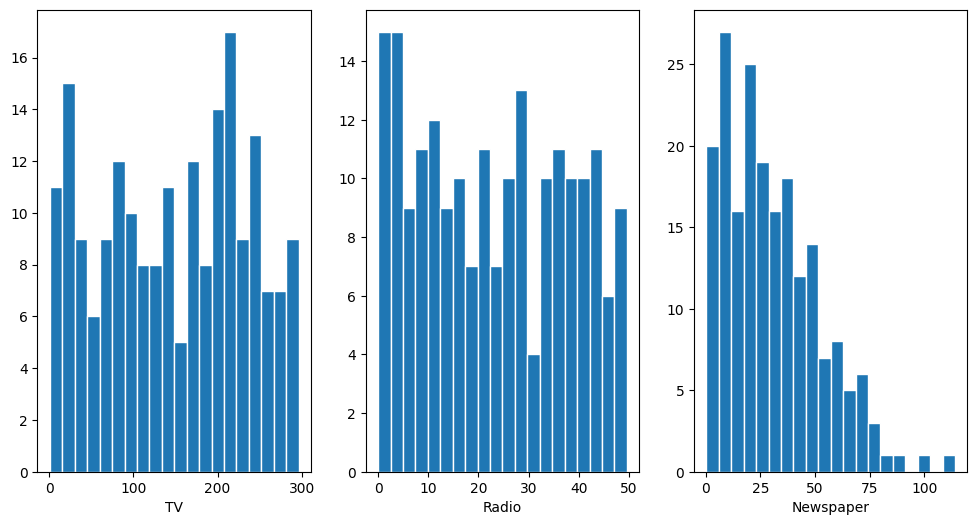

In [6]:
cols = df.columns.drop("Sales")

plt.figure(figsize=(12,6))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=20, edgecolor="w")
    plt.xlabel(col)

plt.show()

In [7]:
#df["Newspaper"] = np.log1p(df["Newspaper"])

# cols = df.columns.drop("Sales")

# plt.figure(figsize=(12,6))
# for i, col in enumerate(cols, 1):
#     plt.subplot(1, 3, i)
#     plt.hist(df[col], bins=20, edgecolor="w")
#     plt.xlabel(col)

# plt.show()

# Analyses bibivariées

Relation claire et croissante ente les investissement TV et les ventes => en fait un bon prédicteur.

La variable Radio présente une relation positive avec les ventes mais plus diffuse, plus dispersion.

En revanche, Newspaper montre aucunne relation visible avec les ventes => suggère que Newspaper pourrait être exclue du modèlke sans perte significative de la performance du modèle.

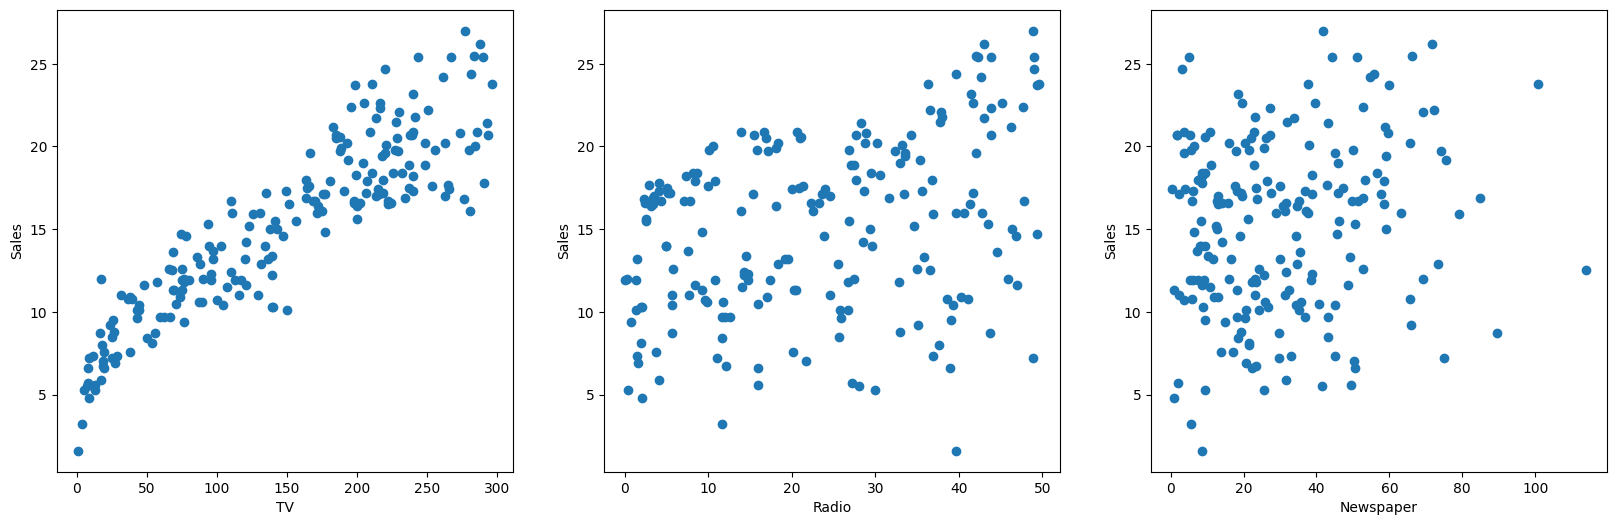

In [8]:
cols = df.columns.drop("Sales")

plt.figure(figsize=(20,6))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[col], df["Sales"])
    plt.ylabel("Sales")
    plt.xlabel(col)

plt.show()

## Étude des corrélations

L'analyse des corrélations confirme les observation précédentes. TV est fortement corrélé avec les ventes => relation linéaire oslide.

Radio présente une corrélation modérée => effet réel sur le modèle mais moins marqué que pour tV

On va exclure Newspaper pour éviter les bruits parasites.

In [9]:
df.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


# 2. Préparation des données

## Détection et gestion des outliers

In [10]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound, 
        upper_bound, 
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )

print("Outliers TV :\n", detect_outliers(df, "TV")[2], "\n")
print("Outliers Radio :\n", detect_outliers(df, "Radio")[2], "\n")
print("Outliers Newspaper :\n", detect_outliers(df, "Newspaper")[2], "\n")
print("Outliers Sales :\n", detect_outliers(df, "Sales")[2], "\n")

Outliers TV :
 Empty DataFrame
Columns: [TV, Radio, Newspaper, Sales]
Index: [] 

Outliers Radio :
 Empty DataFrame
Columns: [TV, Radio, Newspaper, Sales]
Index: [] 

Outliers Newspaper :
         TV  Radio  Newspaper  Sales
16    67.8   36.6      114.0   12.5
101  296.4   36.3      100.9   23.8 

Outliers Sales :
 Empty DataFrame
Columns: [TV, Radio, Newspaper, Sales]
Index: [] 



## Train / Test split

In [11]:
X = df[["TV", "Radio"]].values
y = df[["Sales"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

## Standardisation

In [12]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 3. Entraînement et évaluation du modèle

## Entraînement

In [13]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

## Évaluation

Coeffectients du modèle : [[0.87291096 0.32086275]]
MSE : 0.07602555957242715
RMSE : 0.2757273283017611
R² : 0.9363885855961811


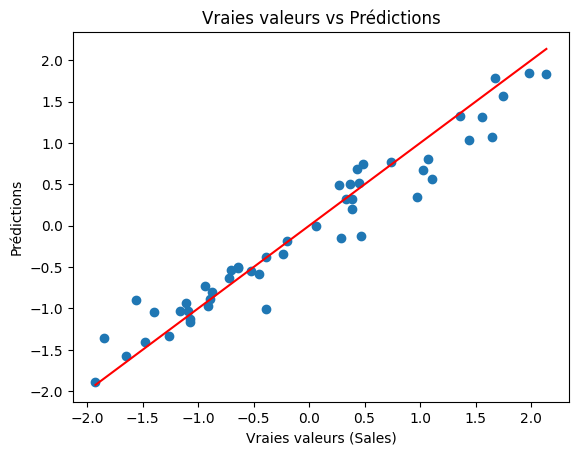

In [16]:
y_pred_scaled = model.predict(X_test_scaled)

# Coefficients
print(f"Coeffectients du modèle : {model.coef_}")

# Metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse)
print("RMSE :", np.sqrt(mse))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Visualisation
plt.scatter(y_test_scaled, y_pred_scaled)
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], color="r")
plt.xlabel("Vraies valeurs (Sales)")
plt.ylabel("Prédictions")
plt.title("Vraies valeurs vs Prédictions")
plt.show()

# 4. Sauvegarde du modèle et des scalers

In [17]:
joblib.dump(model, "models/model_regression.pkl")
joblib.dump(scaler_X, "models/scaler_x.pkl")
joblib.dump(scaler_y, "models/scaler_y.pkl")

['models/scaler_y.pkl']